In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn
from datetime import datetime
import locale
import time
from random import randint
import math
import seaborn as sns

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [12]:
noise_data = pd.read_csv("../Data for visualization/hourly_noisedata_2022.csv", header = 0, sep=',')
noise_data.head()

,month,day,hour,description,lamax,laeq,lamax_standardized,laeq_standardized,date
0,1,1,0,MP 03: Naamsestraat 62 Taste,60.322528,57.126833,1.248969,1.044063,00:00 01-01-2022
1,1,1,0,MP 05: Calvariekapel KU Leuven,53.230972,49.987639,0.114661,-0.103638,00:00 01-01-2022
2,1,1,0,MP 06: Parkstraat 2 La Filosovia,53.666056,50.752000,0.184253,0.019241,00:00 01-01-2022
3,1,1,0,MP 07: Naamsestraat 81,50.056861,47.440222,-0.393044,-0.513162,00:00 01-01-2022
4,1,1,1,MP 03: Naamsestraat 62 Taste,53.033583,50.853806,0.083088,0.035608,01:00 01-01-2022


In [13]:
noise_data = noise_data[noise_data["description"] == "MP 03: Naamsestraat 62 Taste"]
print(noise_data)

       month  day  hour                   description      lamax       laeq   
0          1    1     0  MP 03: Naamsestraat 62 Taste  60.322528  57.126833  \
4          1    1     1  MP 03: Naamsestraat 62 Taste  53.033583  50.853806   
8          1    1     2  MP 03: Naamsestraat 62 Taste  52.173702  50.049903   
12         1    1     3  MP 03: Naamsestraat 62 Taste  50.821311  48.964907   
16         1    1     4  MP 03: Naamsestraat 62 Taste  49.134851  47.285893   
...      ...  ...   ...                           ...        ...        ...   
55439     12   31    19  MP 03: Naamsestraat 62 Taste  55.340278  53.559333   
55445     12   31    20  MP 03: Naamsestraat 62 Taste  53.803528  52.055583   
55451     12   31    21  MP 03: Naamsestraat 62 Taste  52.387139  50.424556   
55457     12   31    22  MP 03: Naamsestraat 62 Taste  53.031611  51.030861   
55463     12   31    23  MP 03: Naamsestraat 62 Taste  59.199583  56.661017   

       lamax_standardized  laeq_standardized       

In [14]:
#Impute single observation
noise_series = pd.Series(noise_data['laeq'])
noise_series.loc[9430] = 50.700694
noise_series = noise_series.sort_index()
noise_series = noise_series.reset_index().drop('index', axis = 1)

In [15]:
weather_data = pd.read_csv("../Data for visualization/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_cont = weather_data[['LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDSPEED', 'LC_TEMP_QCL3']]

In [16]:
cont_features = pd.concat([noise_series, weather_cont], axis=1)
cont_features.rename(columns={"laeq": "Noise (A-weighted hourly avg)", "LC_RAININ": "Rain intensity", "LC_DAILYRAIN": "Cumulative rain",
                              "LC_WINDSPEED": "Windspeed", "LC_TEMP_QCL3": "Temperature"},
    inplace=True,)
print(cont_features)

      Noise (A-weighted hourly avg)  Rain intensity  Cumulative rain   
0                         57.126833        0.000023         0.002997  \
1                         50.853806        0.000019         0.002174   
2                         50.049903        0.000003         0.000360   
3                         48.964907        0.000007         0.000000   
4                         47.285893        0.000009         0.000000   
...                             ...             ...              ...   
8755                      53.559333        0.000074         0.002981   
8756                      52.055583        0.000077         0.002981   
8757                      50.424556        0.000077         0.002988   
8758                      51.030861        0.000074         0.002991   
8759                      56.661017        0.000019         0.002991   

      Windspeed  Temperature  
0      1.487099    15.513391  
1      1.465571    15.770757  
2      0.389565    13.100358  
3      0.22

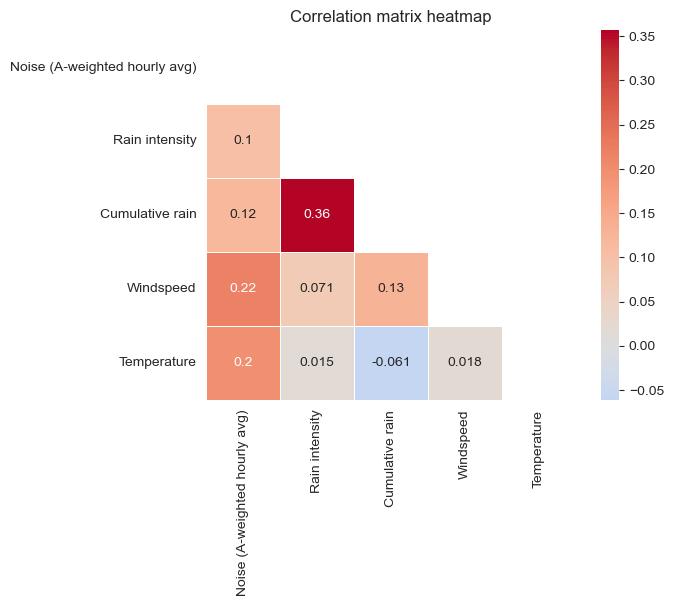

In [17]:
corr_matrix = cont_features.corr()
# Generate mask for upper triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Create heatmap
sns.set_style('white')
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
square=True, linewidths=.5, annot=True, xticklabels = True, yticklabels = True)
plt.title('Correlation matrix heatmap')
plt.show()